<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [320]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Operation not permitted
fatal: destination path 'Neutron_Reflect' already exists and is not an empty directory.


In [911]:
# Import Python related required packages


import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle
import random

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pytorch_lightning as pl

In [913]:
seed = 456
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [915]:
#Set these important parameters
#Dimension of the latent space 
d = 10
#Dimension of the graphs
in_d1 = 2
in_d2 = 72
#Number of epochs
num_epochs = 100
#Number of layers
num_layers = 2
#Number of neurons
num_neur=500 


In [917]:
cd Neutron_Reflect/

[Errno 2] No such file or directory: 'Neutron_Reflect/'
/Users/victorli/Desktop/vsc/Neutron_Reflect-main/Neutron_Reflect/Neutron_Reflect


In [919]:
#Stored those numpy arrays
data_path = './data/'
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
# expt_arr_o = np.loadtxt(os.path.join(data_path,'flipped_sorted_no_nano_expt.dat')).T
# expt_arr = np.zeros_like(expt_arr_o)
# # expt_arr[0] = 1791.5076453352374 - expt_arr_o[0]
# expt_arr[0] = expt_arr_o[0]
# expt_arr[1] = expt_arr_o[1]
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))
# t_sld_arr = np.load(os.path.join(data_path,'train_data.npy'))
# params_arr = np.load(os.path.join(data_path,'train_pars.npy'))

In [921]:
expt_arr.shape ,sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype, expt_arr.dtype

((2, 72),
 (5942, 2, 72),
 (5942, 3),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

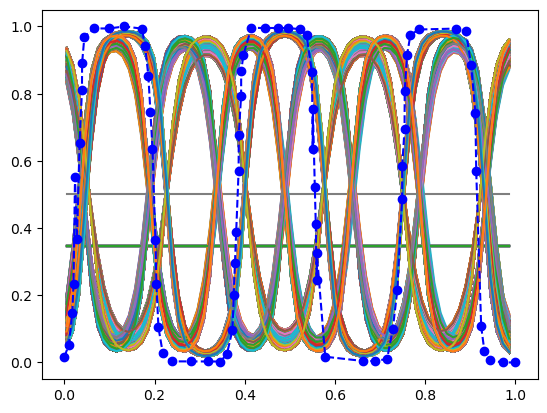

In [336]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0],sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [337]:
# #Normalize labels

# x_val=params_arr[:,0]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)
# params_arr[:,0] = (params_arr[:,0] - x_min_expt)/(x_max_expt - x_min_expt)

# x_val=params_arr[:,1]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)
# params_arr[:,1] = (params_arr[:,1] - x_min_expt)/(x_max_expt - x_min_expt)

# x_val=params_arr[:,2]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)
# params_arr[:,2] = (params_arr[:,2] - x_min_expt)/(x_max_expt - x_min_expt)

In [340]:
# #Check normalization worked

# x_val=params_arr[:,0]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)

# x_val=params_arr[:,1]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)

# x_val=params_arr[:,2]
# x_min_expt = x_val.min()
# x_max_expt = x_val.max()
# print('x-range = ', x_min_expt, ' to ',x_max_expt)


In [342]:
#Find the flat lines in the sld plot
flat_lines_index = []
# icont = 0
for x in range(sld_arr.shape[0]):
  xmax = sld_arr[x,1,].max()
  xmin = sld_arr[x,1,].min()
  if (xmax - xmin) <= 0.001:
    # icont += 1
    flat_lines_index.append(x)

sld_files = []
for x in range(sld_arr.shape[0]):
    sld_files.append(x)   

len(sld_files), len(flat_lines_index)     

(5942, 40)

In [344]:
#Delete the flat sld lines
myslds = [sld_id for sld_id in range(len(sld_files)) if sld_id not in flat_lines_index]
len(myslds)

5902

In [346]:
n_sld_arr = sld_arr[myslds,:,:]
n_params_arr = params_arr[myslds,:]

n_sld_arr.shape, n_params_arr.shape

((5902, 2, 72), (5902, 3))

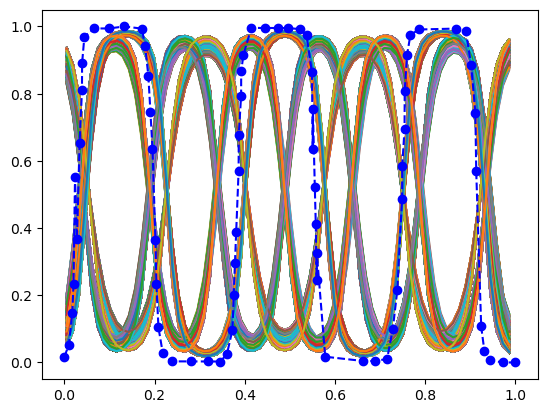

In [348]:
#Replot to make sure the flat lines are not shown
for x in range(n_sld_arr.shape[0]):
  plt.plot(n_sld_arr[x][0],n_sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [509]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [923]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(n_sld_arr,n_params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4721, 2, 72) (4721, 3) (590, 2, 72) (590, 3) (591, 2, 72) (591, 3)


In [941]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

farp


In [571]:
data, label = next(iter(train_loader)) #test
print(data.shape)

torch.Size([50, 2, 72])


In [515]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [517]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  # torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [519]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/100 	 train loss 0.11334875226020813 	 val loss 0.06688109785318375
EPOCH 2/100 	 train loss 0.06462937593460083 	 val loss 0.03787682205438614
EPOCH 3/100 	 train loss 0.01588786393404007 	 val loss 0.0003682305687107146
EPOCH 4/100 	 train loss 0.00023127815802581608 	 val loss 0.00023927284928504378
EPOCH 5/100 	 train loss 0.00021348550217226148 	 val loss 0.00024283400853164494
EPOCH 6/100 	 train loss 0.00020934392523486167 	 val loss 0.00022800659644417465
EPOCH 7/100 	 train loss 0.00020448162104003131 	 val loss 0.00021189388644415885
EPOCH 8/100 	 train loss 0.00019699757103808224 	 val loss 0.00020997248066123575
EPOCH 9/100 	 train loss 0.0001955001789610833 	 val loss 0.0002086799213429913
EPOCH 10/100 	 train loss 0.0001854613801697269 	 val loss 0.00019830912060569972
EPOCH 11/100 	 train loss 0.00016988762945402414 	 val loss 0.00017189669597428292
EPOCH 12/100 	 train loss 0.00016302368021570146 	 val loss 0.0001867390819825232
EPOCH 13/100 	 train loss 0.00016

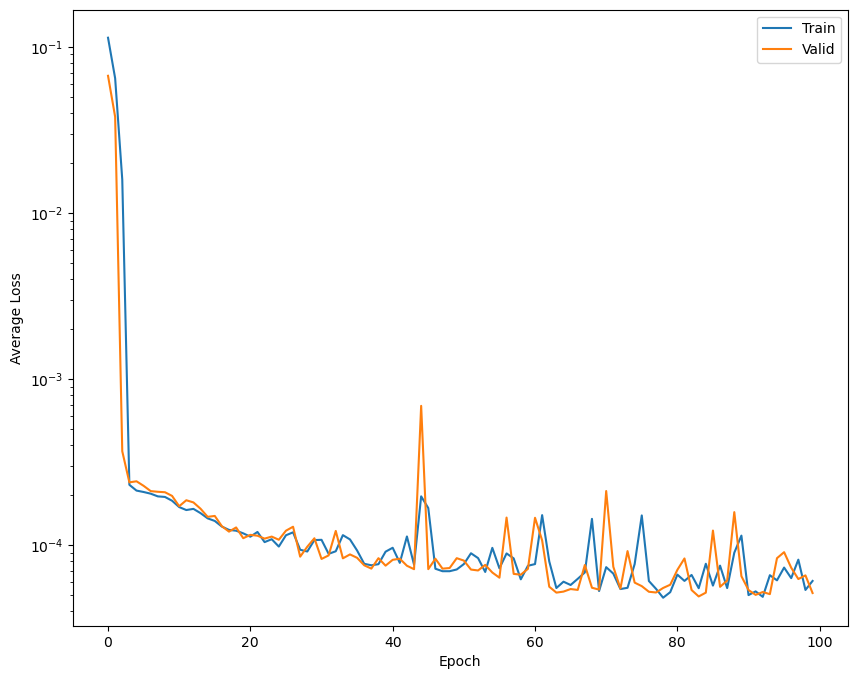

In [521]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 1.7713316992740147e-05
For image 1, the loss = 7.891270070103928e-05
For image 2, the loss = 1.605117904546205e-05
For image 3, the loss = 2.158268034690991e-05
For image 4, the loss = 3.807660687016323e-05
For image 5, the loss = 4.033408549730666e-05
For image 6, the loss = 0.0002002608380280435
For image 7, the loss = 2.4783628759905696e-05
For image 8, the loss = 2.7417139790486544e-05
For image 9, the loss = 2.891240546887275e-05


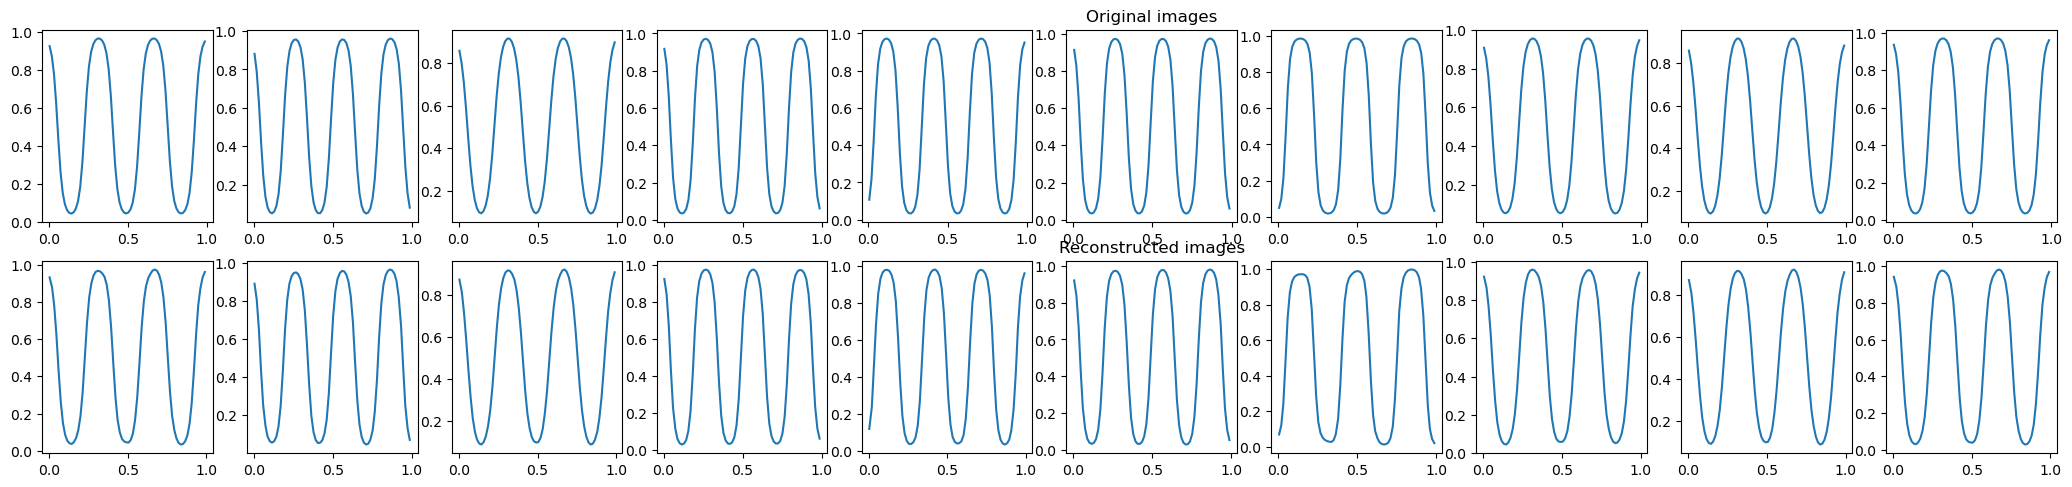

In [523]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

In [23]:
# #Interpolating in the latent space
# #This is similar to a manifold

# def get_img_from_fig(fig, dpi=180):
#     buf = io.BytesIO()
#     fig.savefig(buf, format="png", dpi=dpi)
#     buf.seek(0)
#     img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
#     buf.close()
#     plt.close()
#     img = cv2.imdecode(img_arr,0)

#     return img

# def show_image(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     ax.set_xticks([])
#     ax.set_yticks([])

# encoder.eval()
# decoder.eval()

# with torch.no_grad():
#     images, labels = iter(train_loader).next()
#     images = images.view(images.size(0), -1).to(device) 

#     latent = encoder(images)
#     latent = latent.cpu()

#     mean = latent.mean(dim=0)
#     print(mean)
#     std = (latent - mean).pow(2).mean(dim=0).sqrt()
#     print(std)


#     latent = torch.randn(200, d)*std + mean
#     latent = latent.to(device)
#     img_recon = decoder(latent)
#     img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


# n_img = []
# for i in range(img_recon.shape[0]):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.close()
#     ax.plot(img_recon[i][0],img_recon[i][1])
#     n_img.append(get_img_from_fig(fig))

# n_img = torch.from_numpy(np.asarray(n_img))
# n_img = n_img[:,np.newaxis,:,:]

# fig, ax = plt.subplots(figsize=(20, 8.5))
# show_image(torchvision.utils.make_grid(n_img[:100],10,5))
# plt.show()

In [525]:
nlabel = params_arr.shape[1]
print(nlabel)

for i in range(nlabel):
  label_index = 'label'+str(i)
  # print(label_index)

3


In [527]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,label0,label1,label2
0,2.685465,-2.710284,1.185327,-0.845434,-1.138432,-0.609702,1.132262,1.336411,2.064801,1.872544,0.075,0.248,0.44485
1,1.642837,-1.850663,-2.538414,-0.844628,-1.750167,-1.672913,-0.858311,1.821946,2.088391,1.259934,0.116,0.384,-0.38468
2,2.688402,-2.700358,1.201676,-0.830767,-1.137131,-0.610703,1.140718,1.321295,2.061698,1.882196,0.0699,0.271,0.09328
3,1.644335,-1.855015,-2.531672,-0.848204,-1.748501,-1.669408,-0.854948,1.824123,2.088253,1.258695,0.113,0.446,-0.33565
4,2.844912,-3.025188,1.592453,-1.068141,-1.056909,-0.407815,1.359772,1.488211,2.128096,1.850863,0.14,0.427,0.42306
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4716,2.450468,-0.595003,1.414776,1.396911,-1.187204,-1.309795,1.240284,-0.739394,1.567848,2.889117,0.105,-0.189,0.53316
4717,1.124396,0.886786,-2.937487,1.831748,-1.874062,-2.613780,-1.050768,-0.614384,1.498580,2.317678,0.161,-0.592,-0.14829
4718,1.218460,0.703082,-2.728886,1.709175,-1.848819,-2.530607,-0.939242,-0.520305,1.537077,2.319199,0.0632,-0.544,-0.23304
4719,2.844401,-3.023970,1.591579,-1.067179,-1.057055,-0.408376,1.359261,1.487443,2.127748,1.851031,0.133,0.238,0.23298


In [1085]:
import importlib
importlib.reload(au)
#tests to reload the file
au.testy() 

HELLO BRO!


In [1175]:
timesteps = 1000
num_epochs = 100
batch_size = 50

traine_dataset = au.DiffSet(True, train_dataset)
vale_dataset = au.DiffSet(False, valid_dataset)

traine_loader = torch.utils.data.DataLoader(traine_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
vale_loader = torch.utils.data.DataLoader(vale_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
#continuation
#train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
#dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

#xtrain, ytrain, xval, yval, xtest, ytest = \
#dpre.split_input_arrays(n_sld_arr,n_params_arr, size_split=0.8)

#train_dataset, valid_dataset, train_loader, valid_loader
def diff_model(train_dataset, valid_dataset, train_loader, valid_loader, timesteps, num_epochs, batch_size):
    
    model = au.DiffusionModel(
        128,
        timesteps,
        train_dataset.depth
    )
    
    tb_logger = pl.loggers.TensorBoardLogger(
        "lightning_logs/",
        name="train_dataset",
        version=None,
    )
    
    trainer = pl.Trainer(max_epochs=num_epochs, log_every_n_steps=10, logger=tb_logger)
    #, logger=tb_logger
    trainer.fit(model, train_loader, valid_loader)

    return model

In [1169]:
traine_dataset.size*traine_dataset.size

5184

In [1161]:
for i in vale_loader:
    print(i.size())

torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([50, 2, 8, 16])
torch.Size([40, 2, 8, 16])


In [ ]:
trained_model = diff_model(traine_dataset, vale_dataset, traine_loader, vale_loader, timesteps, num_epochs, batch_size)

In [26]:
#Plotting the joint distributions for the latent variables

# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(1,1,1)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l2']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_ylabel('l2')
# ax.set_xlabel('l1')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,2)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_ylabel('l3')
# ax.set_xlabel('l1')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,3)
# x = df_encoded_samples['l2']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_ylabel('l3')
# ax.set_xlabel('l1')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

In [27]:
# lv1_vals = np.linspace(1.25,1.75,5)
# lv2_vals = np.linspace(-1.5,-1.4,5)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img_f = decoder(lv_vals)

# for x in range(decoded_img_f.shape[0]):
#   plt.plot(decoded_img_f[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_f[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [28]:
# lv1_vals = np.linspace(2.0,2.5,5)
# lv2_vals = np.linspace(0.6,0.61,5)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img_s = decoder(lv_vals)

# for x in range(decoded_img_s.shape[0]):
#   plt.plot(decoded_img_s[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_s[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [29]:
# lv1_vals = np.linspace(0.25,0.75,5)
# lv2_vals = np.linspace(1.5,1.51,5)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img_t = decoder(lv_vals)

# for x in range(decoded_img_t.shape[0]):
#   plt.plot(decoded_img_t[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_t[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [30]:
# lv1_vals = np.linspace(-0.75,0.00,5)
# lv2_vals = np.linspace(-0.5,-0.49,5)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img_fo = decoder(lv_vals)

# for x in range(decoded_img_fo.shape[0]):
#   plt.plot(decoded_img_fo[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_fo[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [31]:
# for x in range(decoded_img_fo.shape[0]):
#   plt.plot(decoded_img_f[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_f[x].cpu().reshape(in_d1,in_d2).numpy()[1])
#   plt.plot(decoded_img_s[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_s[x].cpu().reshape(in_d1,in_d2).numpy()[1])
#   plt.plot(decoded_img_t[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_t[x].cpu().reshape(in_d1,in_d2).numpy()[1])
#   plt.plot(decoded_img_fo[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img_fo[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [32]:
# for x in range(n_sld_arr.shape[0]):
#   plt.plot(n_sld_arr[x][0],n_sld_arr[x][1])
# # plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [33]:
# lv1_vals = np.linspace(-0.75.0,0,100)
# lv2_vals = np.linspace(,0.02,100)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)


# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img = decoder(lv_vals)

# for x in range(decoded_img.shape[0]):
#   plt.plot(decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[1])

In [34]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
# fig = px.scatter(tsne_results, x=0, y=1,
#                  color=df_encoded_samples.label0.astype(str),
#                  labels={'0': 'l1', '1': 'l2'})
# fig.show()

In [35]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
# fig = px.scatter(tsne_results, x=0, y=1,
#                  color=df_encoded_samples.label1.astype(str),
#                  labels={'0': 'l1', '1': 'l2'})
# fig.show()

In [36]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(df_encoded_samples.drop(['label0','label1','label2'],axis=1))
# fig = px.scatter(tsne_results, x=0, y=1,
#                  color=df_encoded_samples.label2.astype(str),
#                  labels={'0': 'l1', '1': 'l2'})
# fig.show()

In [408]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4721, 144]) torch.Size([4721, 144]) torch.Size([4721, 10]) torch.Size([4721, 3])
torch.Size([590, 144]) torch.Size([590, 144]) torch.Size([590, 10]) torch.Size([590, 3])
torch.Size([591, 144]) torch.Size([591, 144]) torch.Size([591, 10]) torch.Size([591, 3])


In [410]:
num_epochs = 1000
num_layers = 2
num_neur = 100

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [412]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [414]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/1000 	 train loss 0.026991046965122223 	 val loss 0.019679853692650795
EPOCH 2/1000 	 train loss 0.020426586270332336 	 val loss 0.019997987896203995
EPOCH 3/1000 	 train loss 0.020086580887436867 	 val loss 0.01958944834768772
EPOCH 4/1000 	 train loss 0.019604574888944626 	 val loss 0.019017305225133896
EPOCH 5/1000 	 train loss 0.019242065027356148 	 val loss 0.018960140645503998
EPOCH 6/1000 	 train loss 0.018832189962267876 	 val loss 0.017920730635523796
EPOCH 7/1000 	 train loss 0.018217362463474274 	 val loss 0.017196061089634895
EPOCH 8/1000 	 train loss 0.018057597801089287 	 val loss 0.016989536583423615
EPOCH 9/1000 	 train loss 0.017168596386909485 	 val loss 0.016626805067062378
EPOCH 10/1000 	 train loss 0.01673373021185398 	 val loss 0.016366170719265938
EPOCH 11/1000 	 train loss 0.016398319974541664 	 val loss 0.01608990877866745
EPOCH 12/1000 	 train loss 0.016007456928491592 	 val loss 0.01648951880633831
EPOCH 13/1000 	 train loss 0.01602821797132492 	 val 

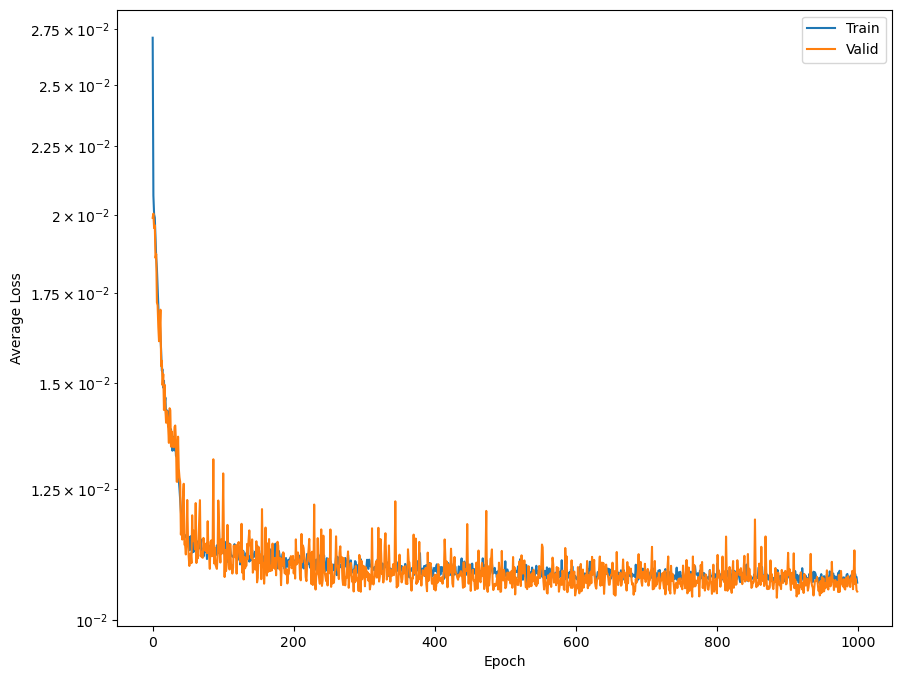

In [58]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [60]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.142862,0.443280,0.128824,0.13,0.486,0.15322
1,0.084906,0.036536,-0.383542,0.091,0.0708,-0.37615
2,0.067543,-0.328962,-0.240173,0.0796,-0.301,-0.27551
3,0.062296,0.362485,0.251372,0.0551,0.484,0.35095
4,0.145120,0.338897,0.327295,0.132,0.168,0.16228
...,...,...,...,...,...,...
586,0.151479,0.352254,-0.298403,0.132,0.404,-0.33317
587,0.141839,-0.315968,0.417479,0.179,-0.419,0.43766
588,0.059494,-0.187677,0.408437,0.0669,-0.213,0.45193
589,0.153631,0.154180,-0.298942,0.127,0.157,-0.17729


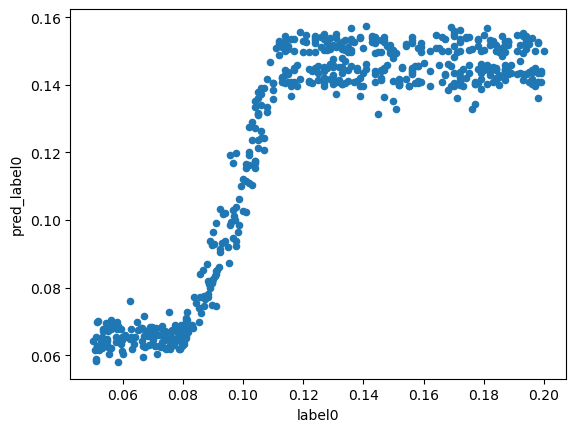

In [62]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

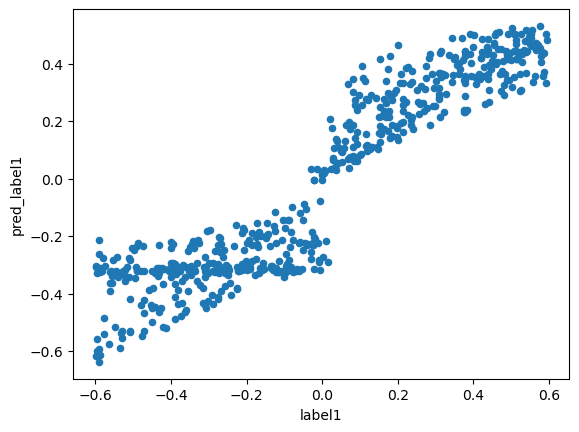

In [64]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

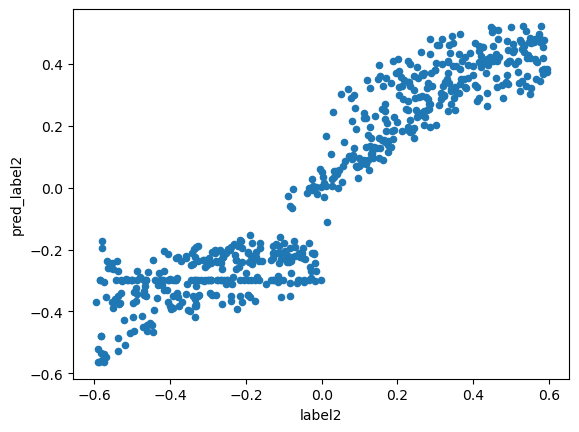

In [66]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [46]:
# df = df_out_samples
# fig = px.scatter(df, x="pred_label0", y="pred_label1")
# fig.show()

 

In [47]:
# df = df_out_samples
# fig = px.scatter(df, x="pred_label1", y="pred_label2")
# fig.show()


In [48]:
# df = df_out_samples
# fig = px.scatter(df, x="pred_label0", y="pred_label2")
# fig.show()


In [68]:
df_new = df_out_samples[(df_out_samples['label0'] >= 0.08) & (df_out_samples['label0'] <= 0.12)] 

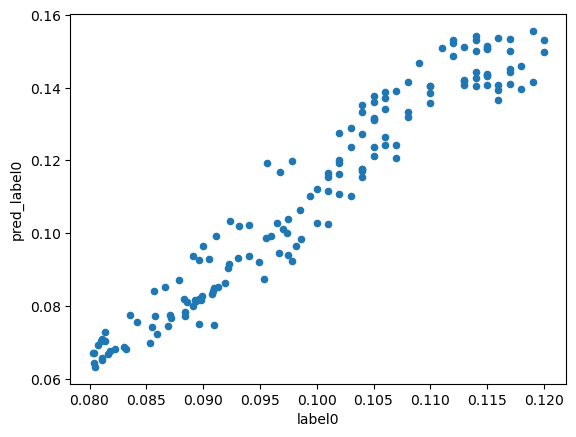

In [70]:
df_new.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

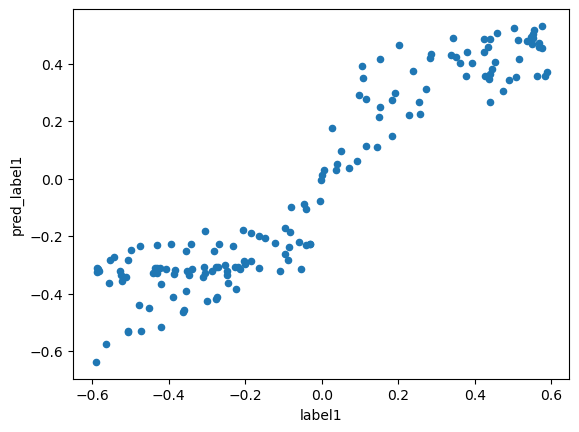

In [72]:
df_new.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

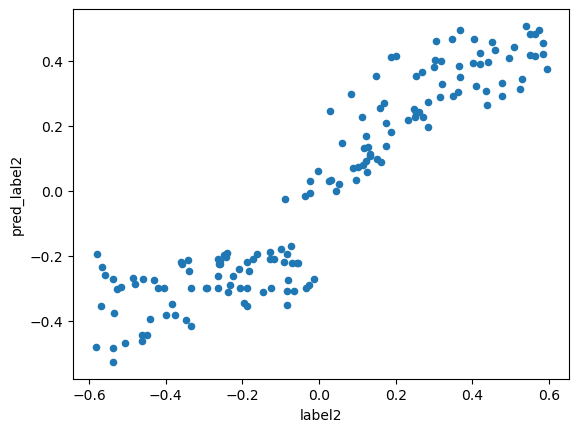

In [74]:
df_new.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [53]:
# df = df_new
# fig = px.scatter_3d(df, x="label0", y="label1", z="label2")
# fig.show()

In [54]:
# df = df_new
# fig = px.scatter_3d(df, x="pred_label0", y="pred_label1", z="pred_label2")
# fig.show()

In [76]:
df_new

,pred_label0,pred_label1,pred_label2,label0,label1,label2
1,0.084906,0.036536,-0.383542,0.091,0.0708,-0.37615
5,0.074068,0.525086,0.019813,0.0855,0.503,0.05279
6,0.093871,0.113917,0.459427,0.0975,0.117,0.45225
9,0.101877,-0.237755,-0.263269,0.0932,-0.0859,-0.22593
18,0.069692,-0.251746,0.420417,0.0853,-0.356,0.58341
...,...,...,...,...,...,...
578,0.077262,0.060152,-0.383642,0.0858,0.0923,-0.3995
579,0.140456,-0.319254,0.241985,0.114,-0.383,0.2617
582,0.142150,0.028640,-0.346753,0.113,0.00553,-0.19544
584,0.138958,-0.187713,-0.468597,0.106,-0.186,-0.50544


In [78]:
len(df_new)

155

In [57]:
# fig = px.histogram(df_new,x='label0')
# fig.show()

In [58]:
# fig = px.histogram(df_new,x='pred_label0')
# fig.show()

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,label0,label1,label2
0,-1.096292,0.740619,0.238893,-0.488116,0.430783,-0.158974,1.076477,-1.041195,-0.448151,0.084703,0.113459,-0.136258,-0.547678


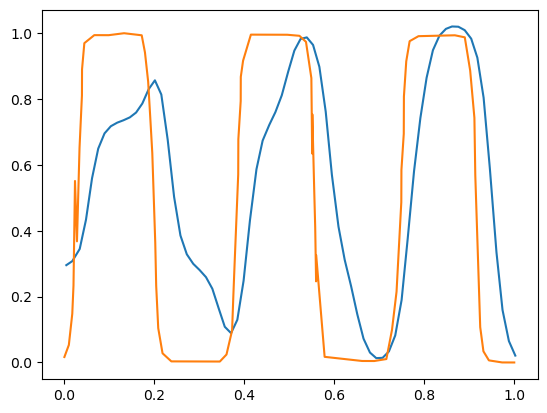

In [80]:
expt_arr_n = expt_arr[np.newaxis,:,:]
# expt_arr_n.shape

expt_labels = []

img = torch.from_numpy(expt_arr_n[0]).float()
img=torch.flatten(img).to(device)

encoder.eval().to(device)
decoder.eval().to(device)
model.eval().to(device)

with torch.no_grad():
  encoded_img  = encoder(img)
  expt_decoded_img = decoder(encoded_img)
  out_label  = model(encoder(img))

  encoded_img = encoded_img.flatten().cpu().numpy()
  out_label = out_label.cpu().numpy()

  # print(encoded_img)
  # print(out_label)
  expt_label = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}

# model.eval().to(device)
# with torch.no_grad():
#   out_label  = model(encoder(img)).cpu().numpy()

for i in range(nlabel):
    label_index = 'label'+str(i)
    expt_label[label_index] = out_label[i]

plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1])

expt_labels.append(expt_label)
df_expt_labels = pd.DataFrame(expt_labels)
df_expt_labels

In [60]:
# #Plotting the joint distributions for the latent variables for the simulated sld files
# fig = plt.figure(figsize=(20, 10))
# ax = fig.add_subplot(1,1,1)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l2']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('l1')
# ax.set_ylabel('l2')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,2)
# x = df_encoded_samples['l1']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('l1')
# ax.set_ylabel('l3')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


# ax = fig.add_subplot(1,3,3)
# x = df_encoded_samples['l2']
# y = df_encoded_samples['l3']
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)
# # ax.set_title('l1')
# sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
# ax.set_xlabel('l2')
# ax.set_ylabel('l3')
# plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

In [61]:
# #Varying l1, l2 and l3 around the values above
# x1 = expt_labels[0]['l1']
# x2 = expt_labels[0]['l2']
# # x3 = expt_labels[0]['l3']
# lv1_vals = np.linspace(x1-.5,x1+.5,100)
# lv2_vals = np.linspace(x2-.5,x2+.5,100)
# # lv3_vals = np.linspace(x3-.5,x3+.5,100)
# # lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None], lv3_vals[:, None]), axis=-1)
# lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
# lv_vals = torch.from_numpy(lv_vals).float().to(device)

# #Determining the labels and the decoded images for those l1,l2,l3 above
# model.eval().to(device)
# with torch.no_grad():
#   out_label  = model(lv_vals).cpu().numpy()
# # out_label.shape

# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img = decoder(lv_vals)

# for x in range(decoded_img.shape[0]):
#   plt.plot(decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[1])
# plt.plot(expt_arr_n[0][0],expt_arr_n[0][1],'ro',linestyle='dashed')
# plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1],'bo',linestyle='dashed') 

# deg_model = pd.DataFrame({'l1':lv_vals.cpu().numpy()[:,0],'l2':lv_vals.cpu().numpy()[:,1],
#                        'label0': out_label[:,0],'label1':out_label[:,1],'label2':out_label[:,2]})
# deg_model

In [62]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [63]:
# cd /content/gdrive/MyDrive

In [64]:
# PATH = '/content/gdrive/MyDrive/'
# torch.save(encoder.state_dict(), PATH + 'l2encoder.pt' )
# torch.save(decoder.state_dict(), PATH + 'l2decoder.pt' )
# torch.save(model.state_dict(), PATH + 'l2mlp.pt' )

In [65]:
# #Reloading the encoder and decoder
# encoder.load_state_dict(torch.load(PATH + 'l2encoder.pt'))
# decoder.load_state_dict(torch.load(PATH + 'l2decoder.pt'))
# model.load_state_dict(torch.load(PATH + 'l2mlp.pt'))

In [82]:
#Cut the original data to include only the region where label0 is similar to pred_label0 
cut_data_lines= []
# icont = 0
for x in range(n_params_arr.shape[0]):
  if (n_params_arr[x,0] <= 0.08 and n_params_arr[x,0] <= 0.11):
    cut_data_lines.append(x)

sld_files = []
for x in range(n_sld_arr.shape[0]):
    sld_files.append(x)   

len(sld_files), len(cut_data_lines) 

(5902, 1146)

In [84]:
#Delete the flat sld lines
myslds = [sld_id for sld_id in range(len(sld_files)) if sld_id in cut_data_lines]
len(myslds)

1146

In [86]:
c_sld_arr = n_sld_arr[myslds,:,:]
c_params_arr = n_params_arr[myslds,:]

c_sld_arr.shape, c_params_arr.shape

((1146, 2, 72), (1146, 3))

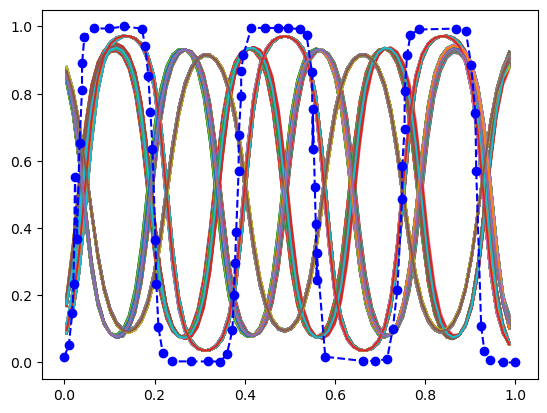

In [88]:
#Replot to make sure the flat lines are not shown
for x in range(c_sld_arr.shape[0]):
  plt.plot(c_sld_arr[x][0],c_sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')